In [2]:
	
%pip install langchain unstructured[all-docs] pydantic lxml tiktoken

  Using cached protobuf-4.25.4-cp39-cp39-win_amd64.whl.metadata (541 bytes)
INFO: pip is looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
Using cached protobuf-4.25.4-cp39-cp39-win_amd64.whl (413 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.27.3
    Uninstalling protobuf-5.27.3:
      Successfully uninstalled protobuf-5.27.3
  Attempting uninstall: grpcio-status
    Found existing installation: grpcio-status 1.65.4
    Uninstalling grpcio-status-1.65.4:
      Successfully uninstalled grpcio-status-1.65.4
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install langchain-community langchain-core

Note: you may need to restart the kernel to use updated packages.


In [2]:
from typing import Any
import os
from unstructured.partition.pdf import partition_pdf
import os

# Get elements
raw_pdf_elements = partition_pdf(
    filename="C:\Multimodal RAG\Data\Monkey.pdf",
    strategy='hi_res',
    extract_images_in_pdf=True,
    extract_image_block_types=["Image"],
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    extract_image_block_output_dir="Monkey_extract",
)

The PDF <_io.BufferedReader name='C:\\Multimodal RAG\\Data\\Monkey.pdf'> contains a metadata field indicating that it should not allow text extraction. Ignoring this field and proceeding. Use the check_extractable if you want to raise an error in this case
The PDF <_io.BufferedReader name='C:\\Multimodal RAG\\Data\\Monkey.pdf'> contains a metadata field indicating that it should not allow text extraction. Ignoring this field and proceeding. Use the check_extractable if you want to raise an error in this case


config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
import base64

text_elements = []
#table_elements = []
image_elements = []

# Function to encode images
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

for element in raw_pdf_elements:
    if 'CompositeElement' in str(type(element)):
        text_elements.append(element)
    # elif 'Table' in str(type(element)):
    #     table_elements.append(element)

# table_elements = [i.text for i in table_elements]
text_elements = [i.text for i in text_elements]

In [4]:
text_elements

['Monkey and Crocodile\n\nA Reading A–Z Level J Leveled Book Word Count: 320\n\nul IN os Reading a-z\n\nVisit www.readinga-z.com for thousands of books and materials.\n\nLEVELED BOOK • J\n\nMonkey and  Crocodile  Retold by Karen Mockler • Illustrated by Mark Bowers \n\nek\n\nSnes\n\nee\n\nwww.readinga-z.com\n\nMonkey and Crocodile\n\nA Folktale from India Retold by Karen Mockler Illustrated by Mark Bowers\n\nwww.readinga-z.com\n\nMonkey and Crocodile Level J Leveled Book © Learning A–Z A Folktale from India Retold by Karen Mockler Illustrated by Mark Bowers\n\nAll rights reserved.\n\nwww.readinga-z.com',
 'Monkey lived in a fine fruit tree by the side of a river. He spent his days eating the fruit of the tree and swinging in its branches.\n\nMonkey and Crocodile • Level J\n\n3\n\nOne day, Crocodile took rest under the tree. Monkey greeted Crocodile, saying, “As you are under my tree, that makes you my guest. Allow me to offer you food.”\n\n4\n\nMonkey tossed down fruit after sweet frui

In [6]:
for image_file in os.listdir("C:\Multimodal RAG\Monkey_extract"):
    if image_file.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join("C:\Multimodal RAG\Monkey_extract", image_file)
        encoded_image = encode_image(image_path)
        image_elements.append(encoded_image)

In [13]:
from langchain_ollama import OllamaLLM
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema.messages import HumanMessage, AIMessage

In [9]:
llm = OllamaLLM(model="llama3.1")
llm_vision = OllamaLLM(model="llava")

In [11]:
# Function for text summaries
def summarize_text(text_element):
    prompt = f"Summarize the following text:\n\n{text_element}\n\nSummary:"
    response = llm.invoke([HumanMessage(content=prompt)])
    return response

# Function for table summaries
# def summarize_table(table_element):
#     prompt = f"Summarize the following table:\n\n{table_element}\n\nSummary:"
#     response = llm.invoke([HumanMessage(content=prompt)])
#     return response

# Function for image summaries
def summarize_image(encoded_image):
    prompt = [
        AIMessage(content="You are a bot that is good at analyzing images."),
        HumanMessage(content=[
            {"type": "text", "text": "Describe the contents of this image."},
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encoded_image}"
                },
            },
        ])
    ]
    response = llm_vision.invoke(prompt)
    return response

In [14]:
# Processing text elements with feedback and sleep
text_summaries = []
for i, te in enumerate(text_elements):
    summary = summarize_text(te)
    text_summaries.append(summary)
    #print(f"{i + 1}th element of texts processed.")

In [15]:
text_summaries

['There is no text to summarize. The provided text appears to be a metadata description of a book, including information about its reading level, author, illustrator, and publisher, but does not contain any actual content or story to summarize.',
 'Here is a summary of the text:\n\nA monkey lives in a tree near a river, where he befriends a crocodile who visits daily for fruit. One day, the crocodile invites the monkey to cross the river with him for dinner, but reveals his true intentions - to eat the monkey. However, the quick-thinking monkey outwits the crocodile by pretending to go fetch his "heart" and luring the crocodile back to his tree, where he escapes. The crocodile is left angry and ashamed, and from then on, monkeys have never trusted crocodiles.',
 "It looks like there's no actual text to summarize. The provided text only contains a glossary title and a summary label, but nothing to summarize. Would you like to provide some actual text for me to work with? I'd be happy to

In [16]:
# Processing image elements with feedback and sleep
image_summaries = []
for i, ie in enumerate(image_elements):
    summary = summarize_image(ie)
    image_summaries.append(summary)
    #print(f"{i + 1}th element of images processed.")

In [17]:
image_summaries

[" This is a complex image containing various texts, symbols and patterns. The text appears to be in different languages or codes, with some parts being garbled or unreadable.\n\nAt the top left corner, there is text that looks like a programming language or code, possibly Python, but it's not clear what it means without additional context. The middle part of the image contains more indecipherable text, while the bottom right shows a sequence of characters that could be interpreted as binary digits (0s and 1s) or base64 encoding.\n\nThe center of the image has a circular pattern with some sort of geometric shapes within it. The overall composition is abstract and does not convey any clear message or purpose without additional information. It seems to be an artistic piece rather than functional text. ",
 ' This is a base64 encoded string. When decoded, it reads as follows:\n\n"Василие напускал тебя и ушел с тебя в стадиом, а ты пошел в соревнование. В стадиом нашлись друзьe и ответили, 

In [19]:
%pip install -U sentence-transformers

  Using cached sentence_transformers-3.0.1-py3-none-any.whl.metadata (10 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached sentence_transformers-3.0.1-py3-none-any.whl (227 kB)
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ------------ --------------------------- 3.4/11.0 MB 20.2 MB/s eta 0:00:01
   ------------------------- -------------- 7.1/11.0 MB 19.0 MB/s eta 0:00:01
   ------------------------------------ --- 10.0/11.0 MB 17.2 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 14.9 MB/s eta 0:00:00
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [23]:
from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.chat_models import ChatOllama

embedding = OllamaEmbeddings(model="nomic-embed-text",show_progress=True)

In [24]:
from langchain.vectorstores import FAISS
import os
import uuid
import base64
from IPython import display
from unstructured.partition.pdf import partition_pdf
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain.vectorstores import FAISS
from langchain.retrievers.multi_vector import MultiVectorRetriever



# Create Documents and Vectorstore
documents = []
retrieve_contents = []

for e, s in zip(text_elements, text_summaries):
    i = str(uuid.uuid4())
    doc = Document(
        page_content=s,
        metadata={
            'id': i,
            'type': 'text',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

# for e, s in zip(table_elements, table_summaries):
#     i = str(uuid.uuid4())
#     doc = Document(
#         page_content=s,
#         metadata={
#             'id': i,
#             'type': 'table',
#             'original_content': e
#         }
#     )
#     retrieve_contents.append((i, e))
#     documents.append(doc)

for e, s in zip(image_elements, image_summaries):
    i = str(uuid.uuid4())
    doc = Document(
        page_content=s,
        metadata={
            'id': i,
            'type': 'image',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)


# Create the vector database
vectorstore = FAISS.from_documents(documents=documents, embedding=embedding)

OllamaEmbeddings: 100%|██████████| 21/21 [00:51<00:00,  2.47s/it]


In [25]:
vectorstore.save_local("faiss_index_pdf") 

In [28]:
# Load the FAISS index with custom embeddings
db = FAISS.load_local("faiss_index_pdf", embeddings=embedding, allow_dangerous_deserialization=True)

# Define the prompt template for the LLMChain
prompt_template = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.
Answer the question based only on the following context, which can include text, images, and tables:
{context}
Question: {question}
Don't answer if you are not sure and decline to answer and say "Sorry, I don't have much information about it."
Just return the helpful answer in as much detail as possible.
Answer:
"""

In [29]:
qa_chain = LLMChain(llm=llm, prompt=PromptTemplate.from_template(prompt_template))

# Define the answer function to handle queries
def answer(question):
    relevant_docs = db.similarity_search(question)
    context = ""
    relevant_images = []
    for d in relevant_docs:
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'table':
            context += '[table]' + d.metadata['original_content']
        elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
    result = qa_chain.run({'context': context, 'question': question})
    return result, relevant_images

c:\Users\ashsi\anaconda3\envs\RAG\lib\site-packages\langchain_core\_api\deprecation.py:141: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(


In [30]:
result, relevant_images = answer("What did monkey do One day when he saw a crocodile?")

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it]
c:\Users\ashsi\anaconda3\envs\RAG\lib\site-packages\langchain_core\_api\deprecation.py:141: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [32]:
print(result)

Based on the provided text, here is what happened:

One day, Monkey greeted Crocodile who had taken rest under his fine fruit tree by the river. Monkey offered Crocodile food, and they became friends. However, when Crocodile asked Monkey to join him for dinner across the river, he revealed that he intended to eat Monkey. But Monkey outsmarted him by pretending to fetch his heart from his tree, making it impossible for Crocodile to carry him out of the tree once they returned. Monkey then jumped off and escaped, leaving Crocodile angry and ashamed.


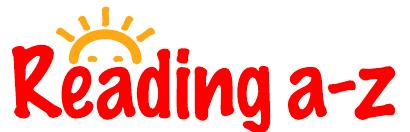

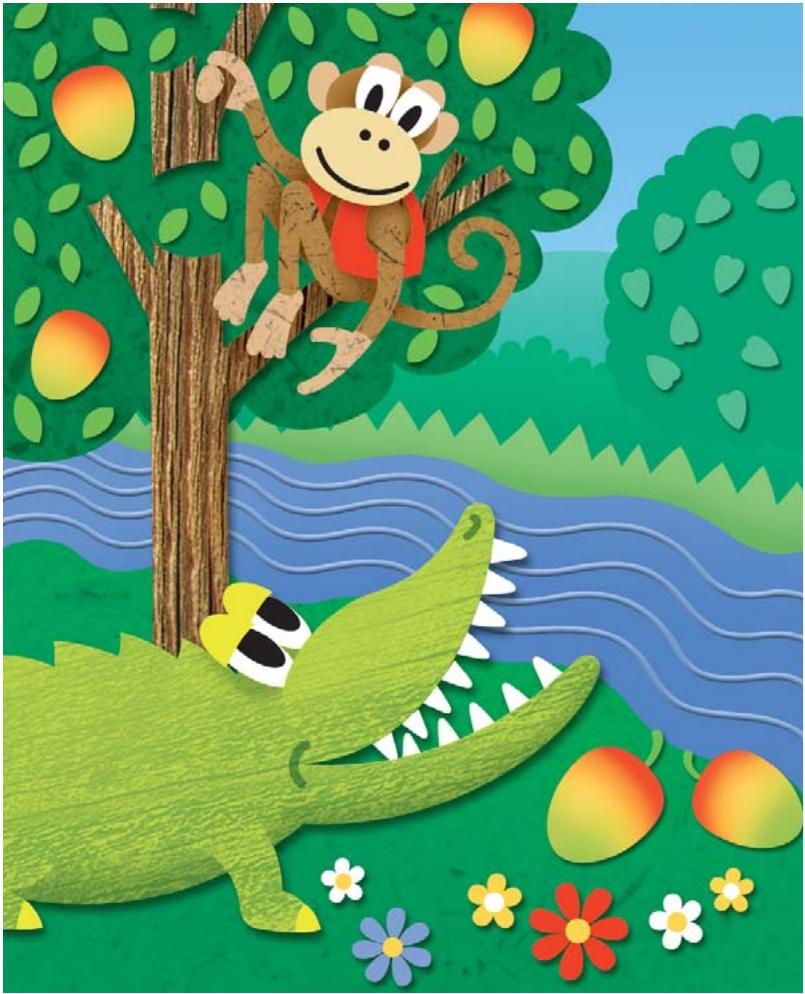

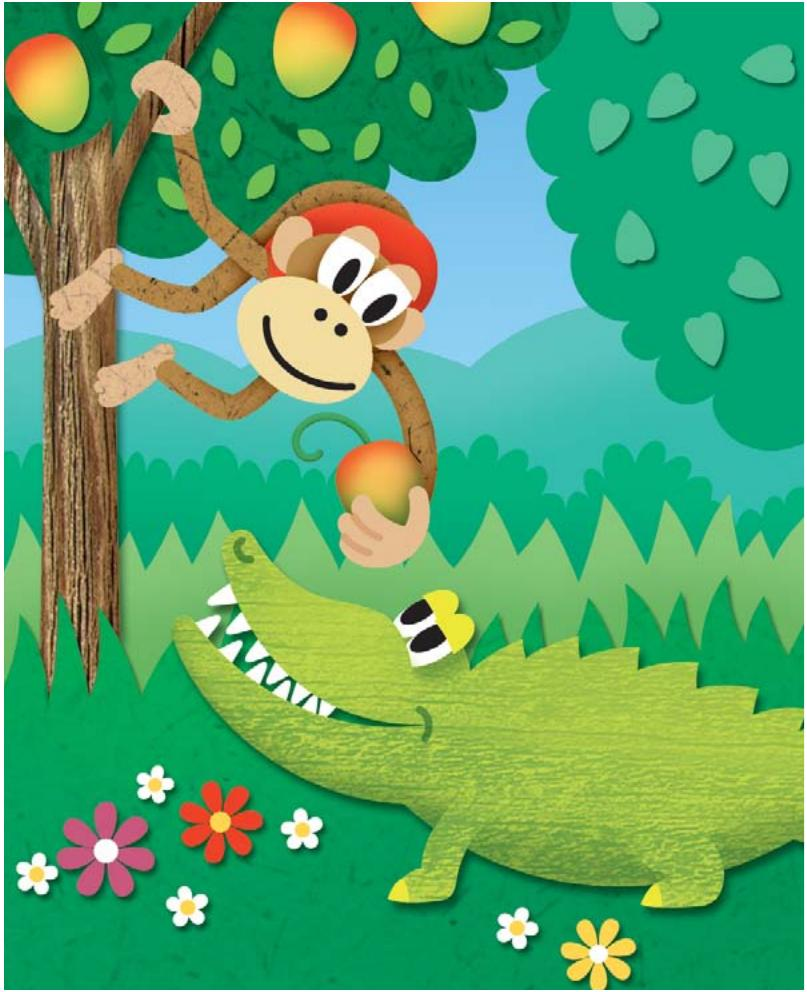

In [35]:
# from IPython.display import Image, display
# image_data = base64.b64decode(relevant_images[1])
# display(Image(image_data))

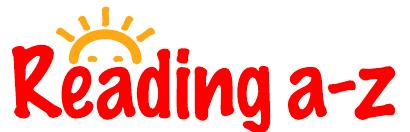

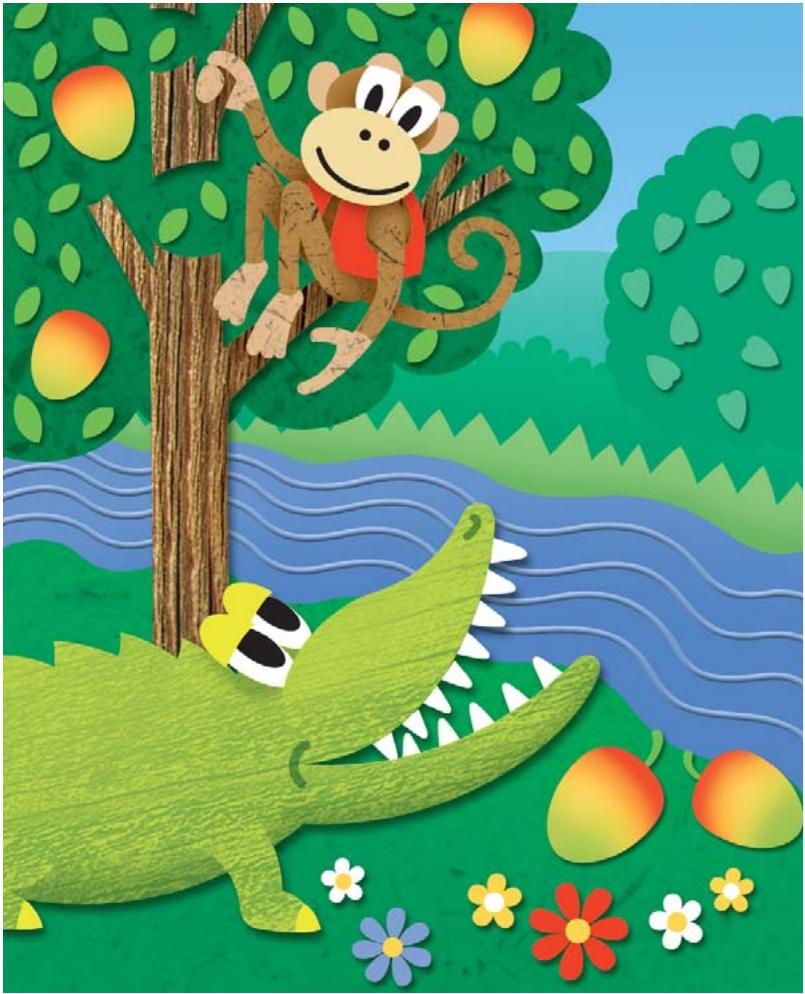

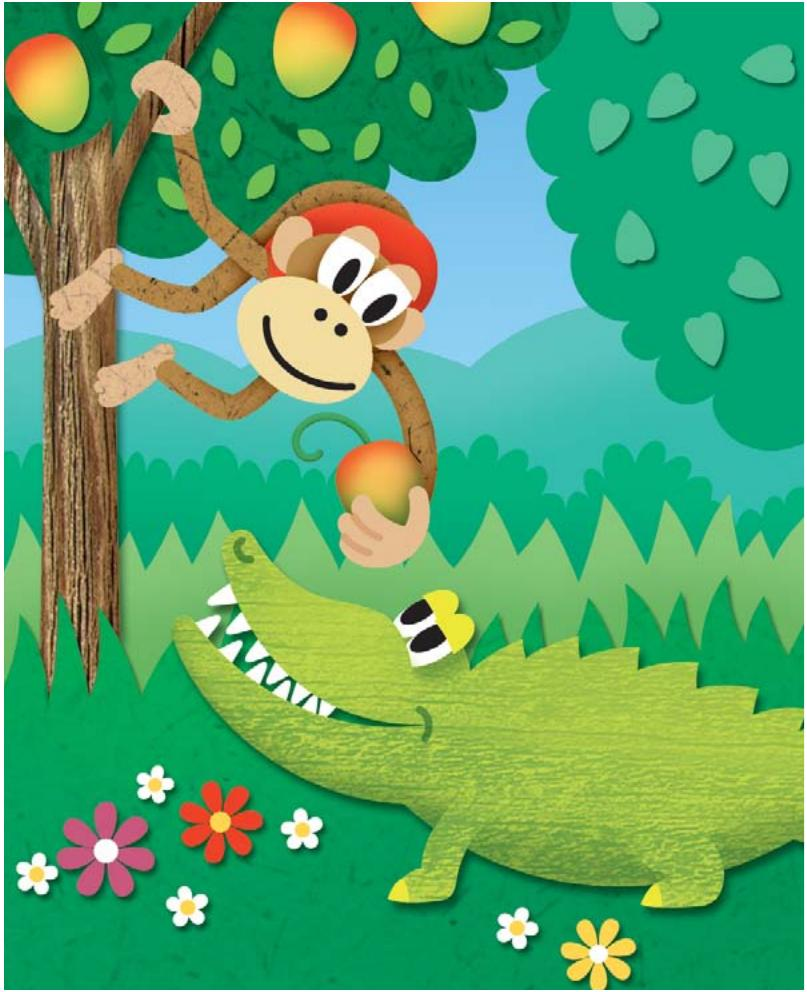

In [36]:
from IPython.display import Image, display
import base64

# Assuming relevant_images is a list of base64 encoded images
for i, encoded_image in enumerate(relevant_images):
    try:
        image_data = base64.b64decode(encoded_image)
        display(Image(image_data))
    except Exception as e:
        print(f"Error displaying image {i}: {e}")

OllamaEmbeddings: 100%|██████████| 1/1 [00:04<00:00,  4.11s/it]


Based on the provided text, the friendship between the monkey and the crocodile begins when Crocodile takes a rest under the tree where Monkey lives. Monkey greets Crocodile and offers him food from the fruit of the tree. After that, Crocodile visits Monkey's tree each day, and eventually, he invites Monkey to cross the river with him for dinner. This marks the start of their interactions, which ultimately lead to a humorous and clever outsmarting of the crocodile by the monkey.


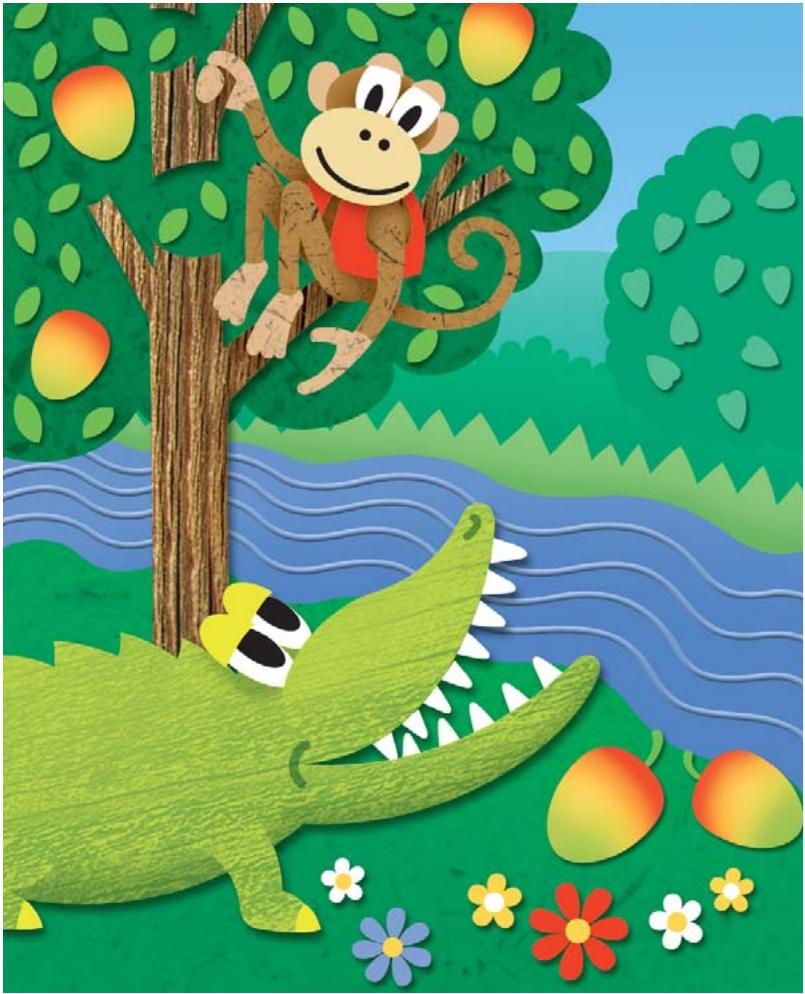

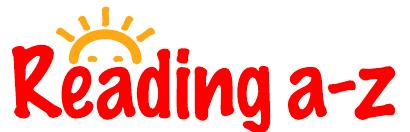

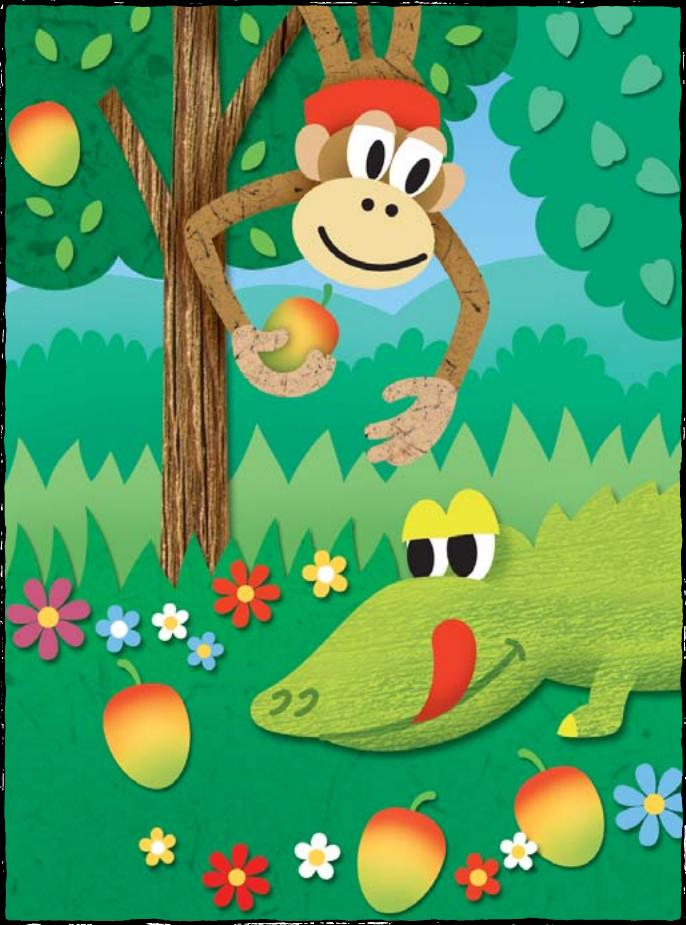

In [40]:
result, relevant_images = answer("How does the friendship between the monkey and the crocodile begin?")
print(result)
for i, encoded_image in enumerate(relevant_images):
    try:
        image_data = base64.b64decode(encoded_image)
        display(Image(image_data))
    except Exception as e:
        print(f"Error displaying image {i}: {e}")


OllamaEmbeddings: 100%|██████████| 1/1 [00:04<00:00,  4.34s/it]


According to the text, when Crocodile invites the Monkey to dinner, he plans to eat him. Specifically, in line 9, Crocodile tells the Monkey: "You are for dinner, my furry little friend. I am taking you home to eat you."


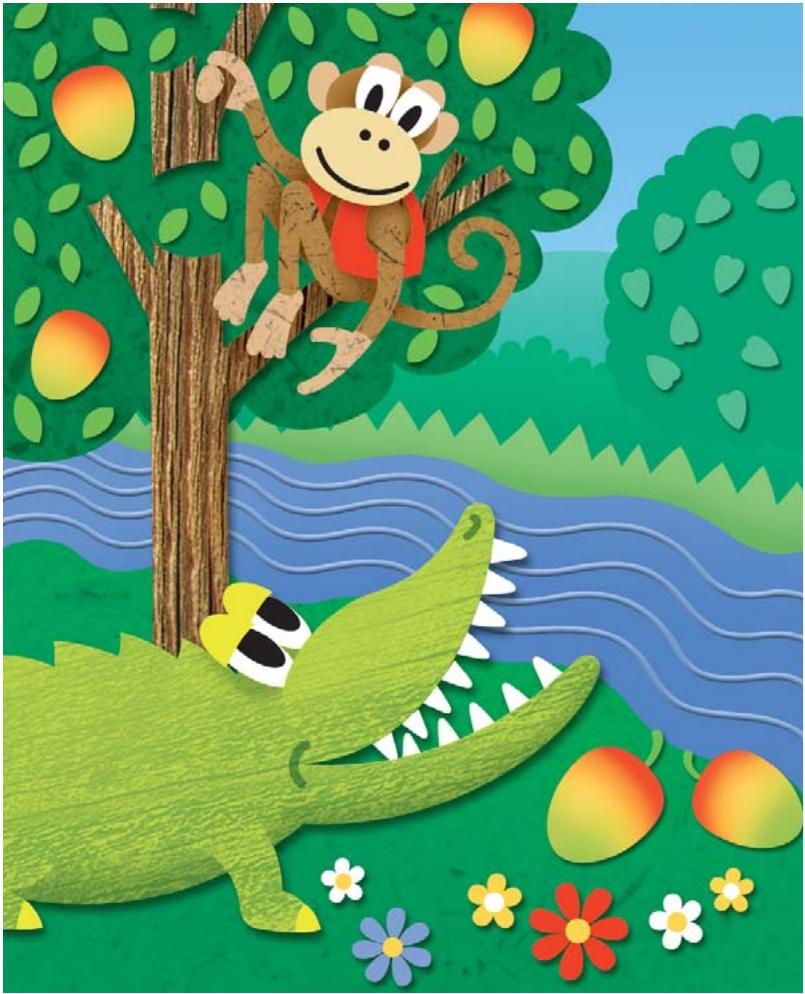

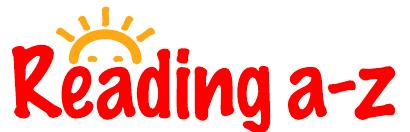

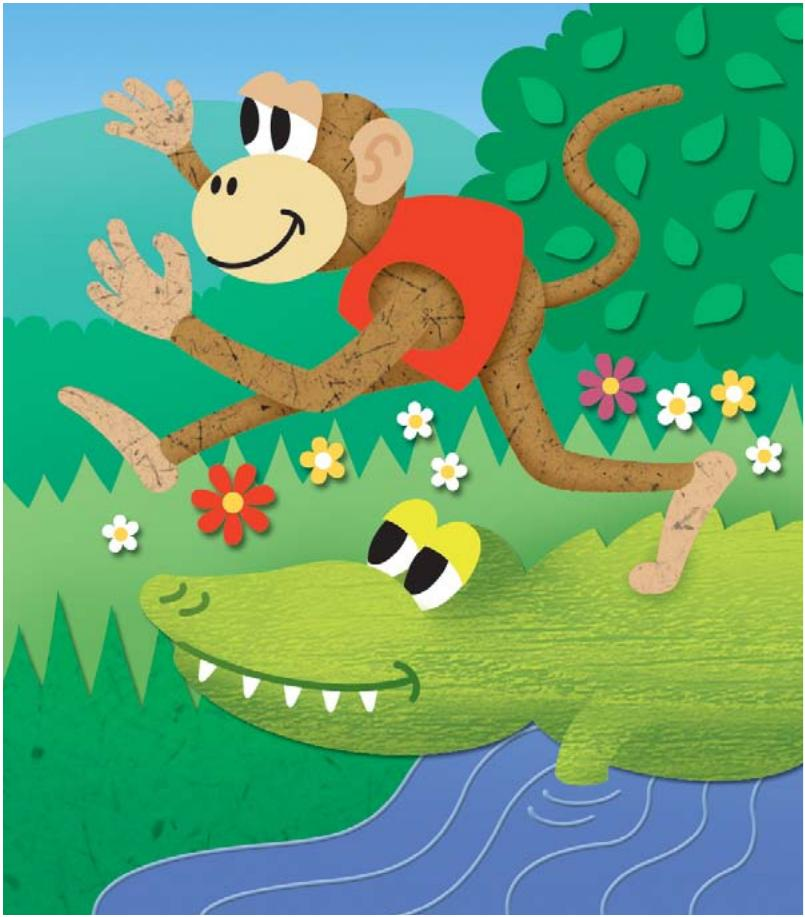

In [41]:
result, relevant_images = answer("What does the crocodile plan to do when he invites the monkey to dinner?")
print(result)
for i, encoded_image in enumerate(relevant_images):
    try:
        image_data = base64.b64decode(encoded_image)
        display(Image(image_data))
    except Exception as e:
        print(f"Error displaying image {i}: {e}")

OllamaEmbeddings: 100%|██████████| 1/1 [00:04<00:00,  4.25s/it]


Based on the text, the monkey manages to escape from the crocodile's plan by outsmarting him. When Crocodile tells Monkey that he is planning to eat him for dinner, Monkey suggests that he fetch his heart (which tastes the best) and asks Crocodile to wait while he gets it. While Crocodile waits and turns back to fetch the heart, Monkey jumps off the crocodile's back and climbs out of reach, laughing at Crocodile. This clever trick allows Monkey to escape from being Crocodile's dinner, and as a result, monkeys have never trusted crocodiles since then.


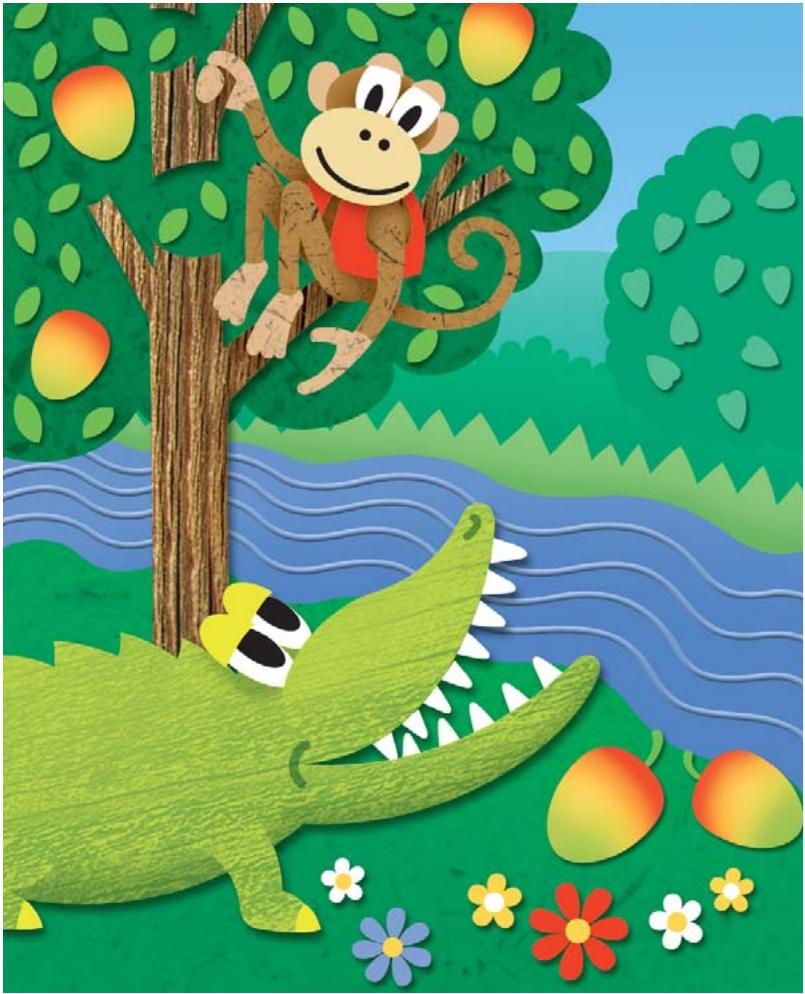

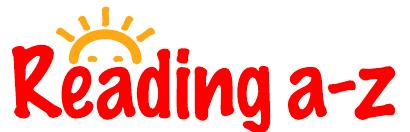

In [42]:
result, relevant_images = answer("How does the monkey manage to escape from the crocodile's plan?")
print(result)
for i, encoded_image in enumerate(relevant_images):
    try:
        image_data = base64.b64decode(encoded_image)
        display(Image(image_data))
    except Exception as e:
        print(f"Error displaying image {i}: {e}")

OllamaEmbeddings: 100%|██████████| 1/1 [00:04<00:00,  4.48s/it]


Based on the provided text context, there is no image or description of a monkey in the river. The story mentions that Monkey lives in a tree by the side of a river and later crosses the river with Crocodile, but it does not depict a specific scene of a monkey in the river.

However, I can suggest that you might be referring to an illustration of the story, which is not included in the provided text context. Since there are multiple images mentioned, but their content is not specified, I am unable to provide a more detailed answer about the image of the monkey in the river.


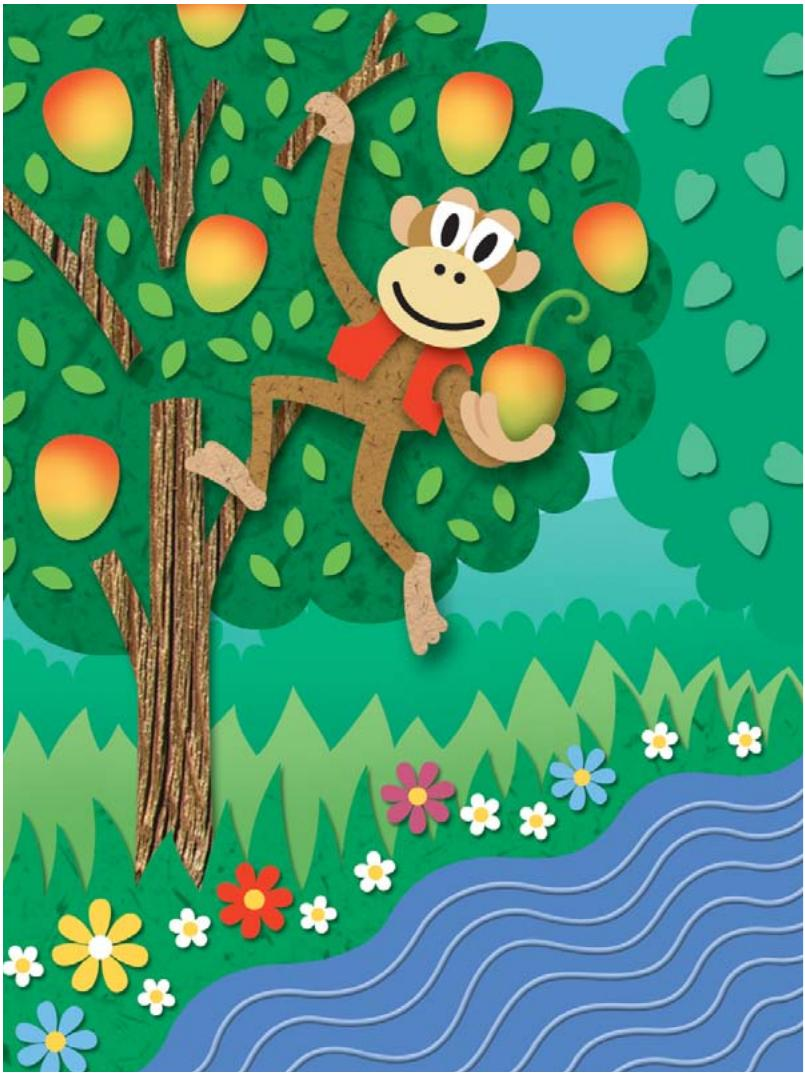

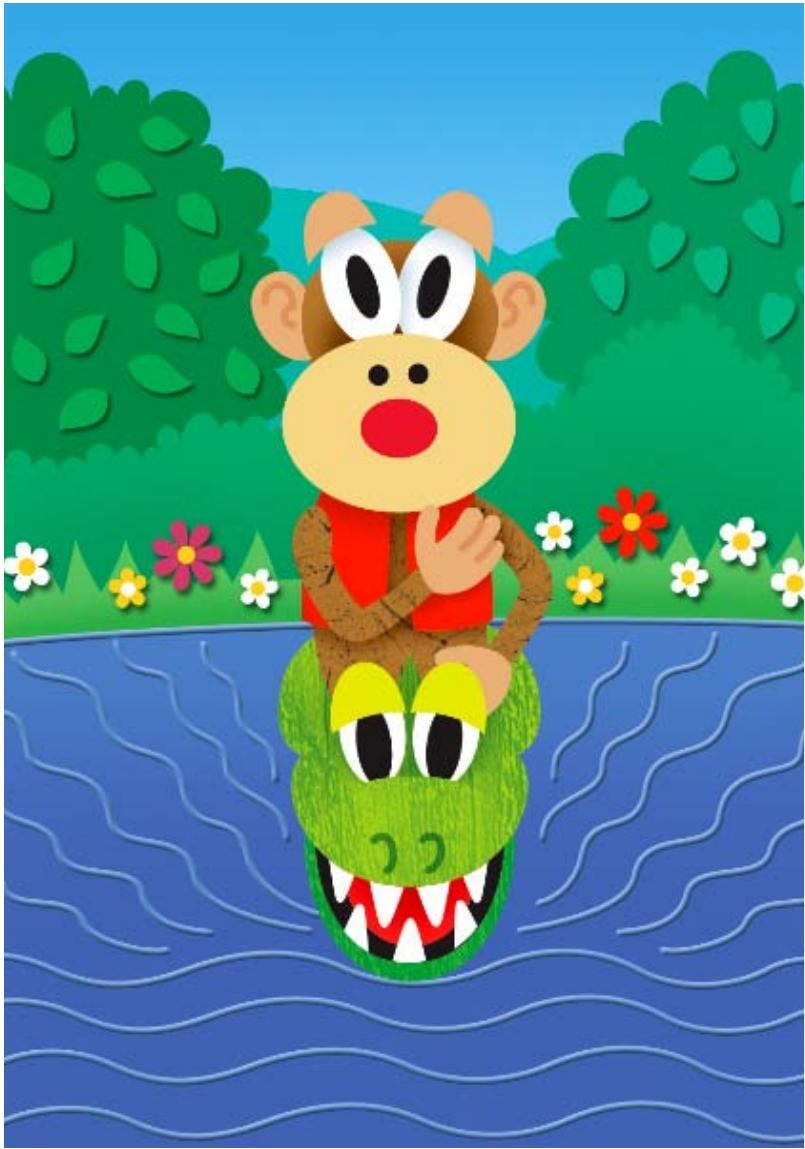

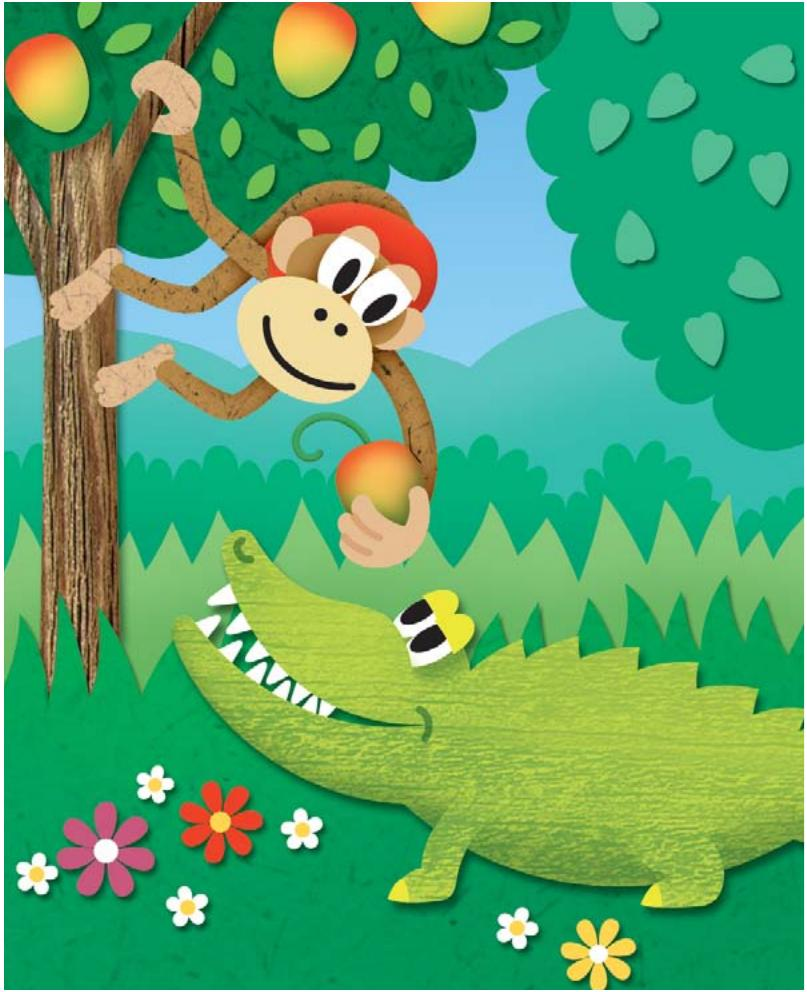

In [44]:
result, relevant_images = answer('''Give me images of the monkey in river''')
print(result)
for i, encoded_image in enumerate(relevant_images):
    try:
        image_data = base64.b64decode(encoded_image)
        display(Image(image_data))
    except Exception as e:
        print(f"Error displaying image {i}: {e}")